# Deep Learning for Deciphering Traffic Signs
_________________________________________________________________________________________________________________________________________________________________________________

##### Contributors:
 Victor Floriano, Yifan Fan, Jose Salerno

## Problem Statement & Motivation
As the world advances towards autonomous vehicles, our team has observed the remarkable efforts of large car manufacturers, who are working with data scientists to develop fully autonomous cars. Our team is excited to contribute to the development of this technology by creating a neural network model that will be able to classify different traffic signs. Our ultimate goal is to assist car makers in overcoming the challenges they may face in implementing neural network models that effectively read traffic signs and further their efforts toward a fully autonomous car or assisted driving. We believe autonomous driving to be an important problem to solve due to the great economic benefits it can generate for car manufacturers and the improvement of general driving safety.

## Data Preparation
 We've selected the German Traffic Sign Recognition Benchmark (GTSRB) as our primary dataset. It's renowned for its complexity, featuring over 50,000 images across more than 40 classes of traffic signs. The GTSRB is publicly accessible through two resources. To efficiently manage the extensive and complex GTSRB dataset, our strategy integrates preprocessing for uniformity, data augmentation for robustness, and batch processing for computational efficiency. We'll employ distributed computing to parallelize operations, enhancing processing speed, and use stratified sampling for quick experimentation without compromising representativeness.



---





# Project Breakdown Summary
1. EDA
3. Model Creation
    - MLP Models
    - CNN Model
    - Pre-trained Model
    - SVM
4. Results
5. Future Work
6. Conclusions
7. Sources

# 1. Exploratory Data Analysis

## Importing Packages

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [6]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
enable_wandb = True
use_gpu = True
gpu_available = torch.cuda.is_available()
gpu_available

/usr4/ba820/jsale017/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [3]:
!pip install wandb -qU

In [10]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable


In [15]:
import os
os.environ['PATH'] += ":/usr4/ba820/jsale017/.local/bin"

In [16]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [37]:
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

In [21]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((56,56)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

dataset_train = ImageFolder(
    'Train',
    transform = train_transforms
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 56, 56])
Label: tensor([1])
tensor([1])


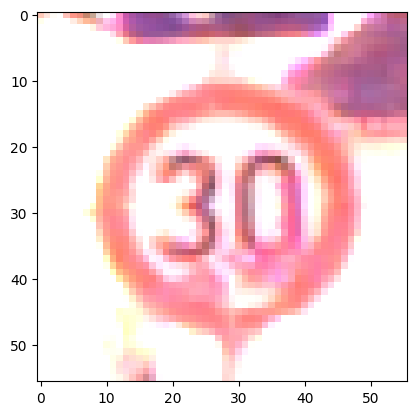

In [22]:
from torch.utils.data import DataLoader

#Trying to display images
dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=1,
)

image, label = next(iter(dataloader_train))
print(image.shape)
print('Label:',label)
print(label)

#Change image into right shape for visualization
image = image.squeeze().permute(1,2,0)

plt.imshow(image)
plt.show()

### Images per Class

Number of images per class:
Class 0: 210
Class 1: 2220
Class 10: 2010
Class 11: 1320
Class 12: 2100
Class 13: 2160
Class 14: 780
Class 15: 630
Class 16: 420
Class 17: 1110
Class 18: 1200
Class 19: 210
Class 2: 2250
Class 20: 360
Class 21: 330
Class 22: 390
Class 23: 510
Class 24: 270
Class 25: 1500
Class 26: 600
Class 27: 240
Class 28: 540
Class 29: 270
Class 3: 1410
Class 30: 450
Class 31: 780
Class 32: 240
Class 33: 689
Class 34: 420
Class 35: 1200
Class 36: 390
Class 37: 210
Class 38: 2070
Class 39: 300
Class 4: 1980
Class 40: 360
Class 41: 240
Class 42: 240
Class 5: 1860
Class 6: 420
Class 7: 1440
Class 8: 1410
Class 9: 1470


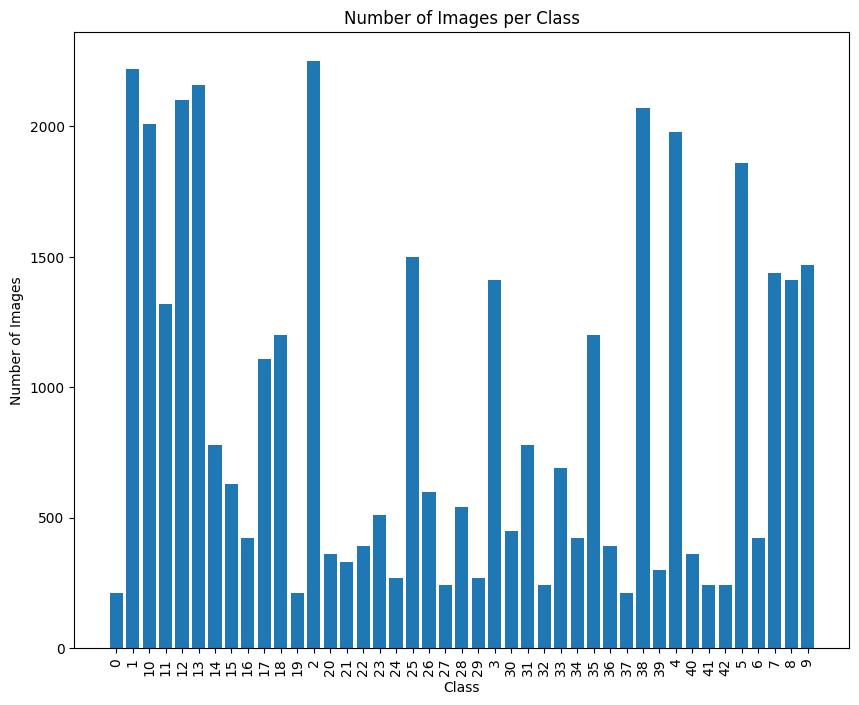

In [23]:
#Counting how many images we have for each class
import matplotlib.pyplot as plt

#Initiate an empty dictionary
class_counts = {}

#Iterate over imgs in dataset_train - which returns the image path and it's
#class label.
for _, label in dataset_train.imgs:

    #Create temp class label
    class_label = dataset_train.classes[label]

    #If the class label is in the dictionary already we add to it, if not
    #we add it to the dictionary and start its value at 1
    if class_label in class_counts:
        class_counts[class_label] += 1
    else:
        class_counts[class_label] = 1


print("Number of images per class:")
for class_name, count in class_counts.items():
    print(f"Class {class_name}: {count}")

#Plot the distribution
plt.figure(figsize=(10, 8))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=90)
plt.show()
     

## Image Dimensions

In [24]:
#Counting how many images we have for each resolution
import imageio.v2 as imageio

#Initiate an empty dictionary for resolutions
resolution_counts = {}

#Iterate over each image path

iteration = 0

for img_path, _ in dataset_train.imgs:

    #Load image
    image = imageio.imread(img_path)

    #Get the total resolution
    total_resolution = (image.shape[1], image.shape[0])

    #Following a similar approach to the classes, if the resolution pair
    #is not in the dictionary we create an entry, if it is we add 1 to the count
    if total_resolution in resolution_counts:
        resolution_counts[total_resolution] += 1
    else:
        resolution_counts[total_resolution] = 1

    #Keep track of iteration - check to see if code is working
    if iteration % 1000 == 0:

      print('iteration:', iteration)

    iteration += 1

#Display resolution distribution
print("Resolution distribution:")
for total_resolution, count in sorted(resolution_counts.items()):
    print(f"{total_resolution}: {count}")
     

iteration: 0
iteration: 1000
iteration: 2000
iteration: 3000
iteration: 4000
iteration: 5000
iteration: 6000
iteration: 7000
iteration: 8000
iteration: 9000
iteration: 10000
iteration: 11000
iteration: 12000
iteration: 13000
iteration: 14000
iteration: 15000
iteration: 16000
iteration: 17000
iteration: 18000
iteration: 19000
iteration: 20000
iteration: 21000
iteration: 22000
iteration: 23000
iteration: 24000
iteration: 25000
iteration: 26000
iteration: 27000
iteration: 28000
iteration: 29000
iteration: 30000
iteration: 31000
iteration: 32000
iteration: 33000
iteration: 34000
iteration: 35000
iteration: 36000
iteration: 37000
iteration: 38000
iteration: 39000
Resolution distribution:
(25, 25): 7
(25, 26): 17
(25, 27): 21
(25, 28): 4
(25, 29): 1
(25, 30): 1
(25, 31): 1
(25, 32): 1
(25, 40): 1
(26, 25): 21
(26, 26): 85
(26, 27): 108
(26, 28): 70
(26, 29): 27
(26, 30): 7
(26, 31): 5
(26, 32): 6
(26, 33): 4
(26, 34): 1
(26, 35): 1
(26, 40): 1
(26, 42): 1
(26, 55): 1
(26, 56): 1
(26, 57): 1


In [25]:
#Retrieving average resolution

#Initialize total pixels and total images count
total_pixels = 0
total_images = 0

#Iterate through the resolution counts dictionary
for resolution, count in resolution_counts.items():
    width, height = resolution

    #Calculate total pixels for this resolution - most are one but we learned this
    #after running the code
    pixels = width * height * count
    total_pixels += pixels

    #Increase the total image count
    total_images += count

# Calculate average pixels per image
average_pixels_per_image = total_pixels / total_images

# Display the average pixels per image
print(f'Average number of pixels per image: {average_pixels_per_image}')
print(f'Achieved through a {round((average_pixels_per_image)**0.5)} by {round((average_pixels_per_image)**0.5)} image - approximately')

Average number of pixels per image: 3109.82552475197
Achieved through a 56 by 56 image - approximately


### Visualizing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 56, 56])
Label: tensor([24])
tensor([24])


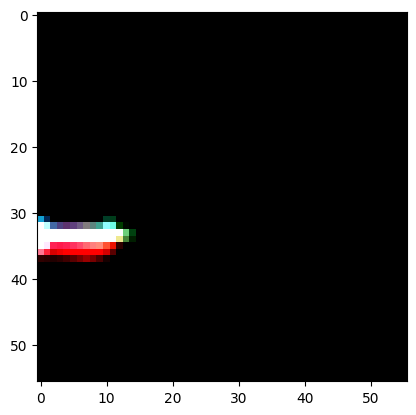

In [26]:
from torch.utils.data import DataLoader

#Trying to display images
dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=1,
)

image, label = next(iter(dataloader_train))
print(image.shape)
print('Label:',label)
print(label)

#Change image into right shape for visualization
image = image.squeeze().permute(1,2,0)

plt.imshow(image)
plt.show()

# 2. Model Creation 

In [27]:
configs = {
    "experiment_name": "First Experiement Traffic Signs ",
    "freeze_feature_extraction_layers": False,
    "pretrained":False,
    "efficientnet":False,
    "data_augmentation":True,
    "transferlearning": True,

    # Data
    "img_dimensions" : (3,56,56),
    "batch_size" : 32,
    "num_classes" : 43,

    # CNN
    "filter_sizes" : [4,8],
    "kernel_size" : 5,
    "stride": 2,
    "padding":1,

    #Optimzation
    "learning_rate" : 0.01,
    "epochs" : 70,
    "weight_decay" : 0.00001
}

## Data Augmentation


In [28]:
if configs["data_augmentation"]:
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(0.5),
      transforms.Resize(56),
      transforms.RandomRotation(45),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
else:
  transform = transforms.Compose([
      transforms.Resize(56),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

In [29]:
train_dataset, val_dataset = random_split(dataset_train, [0.8, 0.2])

In [30]:
train_loader = DataLoader(dataset = train_dataset, batch_size = configs['batch_size'], shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = configs['batch_size'], shuffle = False)

In [68]:
wandb.log({
    "epoch": epoch + 1,
    "LR": optimizer.param_groups[0]['lr'],
    "train_accuracy": train_acc.compute(),
    "val_accuracy": test_acc.compute()
})

## Pytorch Sequential MLP

#### Sequential Model

In [69]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(56*56*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc4 = nn.Linear(64, 43)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

In [70]:
model = MLP()

In [71]:
pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [72]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Flatten: 1-1                           --
├─Linear: 1-2                            2,408,704
├─Linear: 1-3                            32,896
├─Linear: 1-4                            8,256
├─Dropout: 1-5                           --
├─Linear: 1-6                            2,795
Total params: 2,452,651
Trainable params: 2,452,651
Non-trainable params: 0

In [73]:
criterion = nn.CrossEntropyLoss()

In [74]:
optimizer = optim.SGD(model.parameters(), momentum=0.8, lr=configs['learning_rate'], weight_decay=configs['weight_decay'])

In [75]:
if enable_wandb:
  wandb.init(
    project="Deciphering Traffic Signs",
    name=configs["experiment_name"],
    config=configs)

LR,▁
epoch,▁
loss,█▆█▆▄▇█▄▄█▁▆▇▇▆▂▃▇▃▄
train_accuracy,▁
val_accuracy,▁
val_loss,█▁
LR,0.01
epoch,1
loss,3.51048
train_accuracy,0.27467
val_accuracy,0.27509


In [76]:
!pip install -U torchmetrics
import torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [77]:
def get_accuracy(dataloader, model):
    num_classes = 43
    acc = torchmetrics.Accuracy(task = 'multiclass', num_classes = num_classes)
    with torch.no_grad():
        for images, labels in dataloader:
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            acc = acc + torch.sum(torch.argmax(outputs, axis = 1) == labels)

        acc = acc / len(dataloader.dataset)
        return acc

In [78]:
def get_loss(loader):
    with torch.no_grad():
        loss = 0
        for i, (images, labels) in enumerate(loader):
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            loss = loss + criterion(outputs, labels)
        return loss/len(loader)

In [79]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), "./best_model.pt")

        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [80]:
if gpu_available and use_gpu:
    model = model.cuda()

In [81]:
import torch.nn.functional as F

early_stopper = EarlyStopper(patience=7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

# Training
for epoch in range(configs["epochs"]):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        if gpu_available and use_gpu:
          images = images.cuda()
          labels = labels.cuda()

        outputs = model(images)
        loss = criteron(outputs, labels)
        loss.backward()
        optimizer.step()

        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})

    train_acc = get_accuracy(train_loader, model)
    test_acc = get_accuracy(val_loader, model)

    validation_loss = get_loss(val_loader)
    wandb.log({"val_loss": validation_loss})

    print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]:.4f}, Validation Loss: {validation_loss:.4f}, Train Accuracy: {train_acc.compute():.4f}, Validation Accuracy: {test_acc.compute():.4f}')
    if enable_wandb:
      wandb.log({"epoch": epoch + 1, "LR": {optimizer.param_groups[0]['lr']}, "train_accuracy": train_acc.item(), "val_accuracy": test_acc.item()})

    scheduler.step(validation_loss)

    if early_stopper.early_stop(validation_loss):
        print("Validation loss hasn't dropped. Early stopping!")
        break

Epoch 1  batch 1 . Training Loss:  3.761127471923828
Epoch 1  batch 101 . Training Loss:  3.759707450866699
Epoch 1  batch 201 . Training Loss:  3.7601304054260254
Epoch 1  batch 301 . Training Loss:  3.7587616443634033
Epoch 1  batch 401 . Training Loss:  3.759596109390259
Epoch 1  batch 501 . Training Loss:  3.756558418273926
Epoch 1  batch 601 . Training Loss:  3.7486143112182617
Epoch 1  batch 701 . Training Loss:  3.7484688758850098
Epoch 1  batch 801 . Training Loss:  3.674344778060913
Epoch 1  batch 901 . Training Loss:  3.706859588623047
Epoch [1/70], LR: 0.0100, Validation Loss: 3.7054, Train Accuracy: 0.1037, Validation Accuracy: 0.0991


AttributeError: 'CompositionalMetric' object has no attribute 'item'

In [82]:
if enable_wandb:
  wandb.finish()

loss,██████▇▇▁▄
val_loss,▁
loss,3.70686
val_loss,3.70541


## Pytoch CNN Model

In [89]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [90]:
model_CNN = MLP()
summary(model_CNN)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Conv2d: 1-1                            1,568
├─Dropout: 1-2                           --
├─Linear: 1-3                            3,444,864
├─Dropout: 1-4                           --
├─Linear: 1-5                            8,256
├─Dropout: 1-6                           --
├─Linear: 1-7                            2,795
Total params: 3,457,483
Trainable params: 3,457,483
Non-trainable params: 0

In [91]:
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters())

In [85]:
early_stopper = EarlyStopper(patience=7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

# Training
for epoch in range(configs["epochs"]):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        if gpu_available and use_gpu:
          images = images.cuda()
          labels = labels.cuda()

        outputs = model(images)
        loss = criteron(outputs, labels)
        loss.backward()
        optimizer.step()

        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})

    train_acc = get_accuracy(train_loader, model)
    test_acc = get_accuracy(val_loader, model)

    validation_loss = get_loss(val_loader)
    wandb.log({"val_loss": validation_loss})

    print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]}, Validation Loss: {validation_loss.item():.4f}, Train Accuracy: {train_acc.item():.4f}, Validation Accuracy: {test_acc.item():.4f}')
    if enable_wandb:
      wandb.log({"epoch": epoch + 1, "LR": {optimizer.param_groups[0]['lr']}, "train_accuracy": train_acc.item(), "val_accuracy": test_acc.item()})

    scheduler.step(validation_loss)

    if early_stopper.early_stop(validation_loss):
        print("Validation loss hasn't dropped. Early stopping!")
        break

Epoch 1  batch 1 . Training Loss:  3.5964715480804443


Error: You must call wandb.init() before wandb.log()

## Pre-trained Model

## Support Vector Machine Model

# 3. Results

# 4. Future Work

# 5. Conclusions

# 6. Sources

## Sources:

- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html